## Sagnac Frequency - Backscatter Correction - RU Longterm

## Imports

In [2]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream
from scipy.signal import hilbert

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [4]:
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data

In [5]:
def __correct_temperature_trend(st, correction, n_shift=0, intercept=False):

    from numpy import roll

    st0 = st.copy()
    if n_shift == 0:
        temperature = st0.select(channel="*T")[0].data
    else:
        temperature = roll(st0.select(channel="*T")[0].data, n_shift)


    if intercept:
        st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature + correction['N_intercept'])
        st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature + correction['N_intercept'])
    else:
        st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature)
        st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature)

    plt.plot(temperature)

    return st0

## Configurations

In [6]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

config['tbeg'] = UTCDateTime("2023-11-01 00:00")
config['tend'] = UTCDateTime("2024-01-22 00:00")


## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

## Configurations

In [7]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

<Figure size 1500x500 with 0 Axes>

(302.3, 303.2)

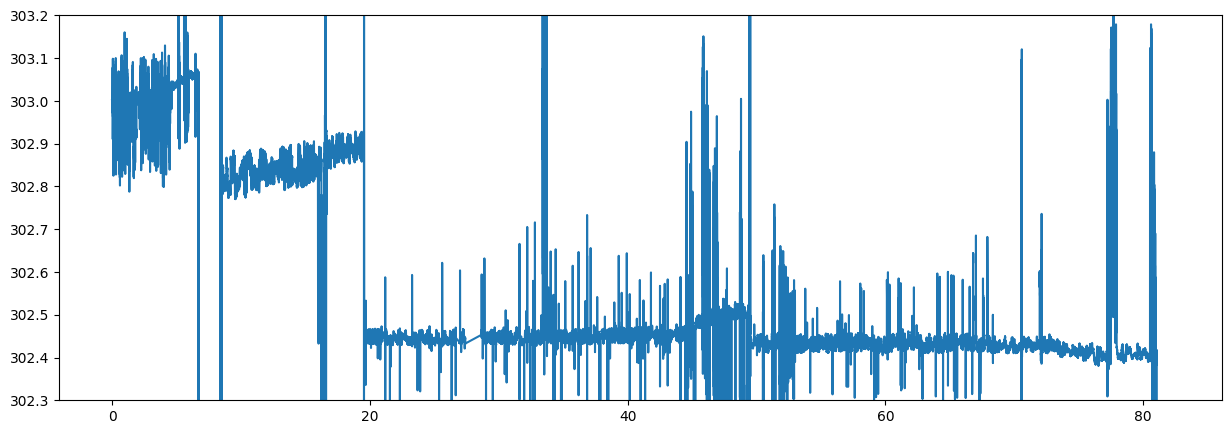

In [8]:
plt.figure(figsize=(15,5))
plt.plot(bs.time_sec/86400, bs.fj_fs)
plt.ylim(302.3, 303.2)

### Cut corrupt data periods

In [9]:
times = [("2023-12-04T09:11", "2023-12-04T18:01")]

for t1, t2 in times:
    bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
    bs['w_s'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.w_s)


bs['fj_fs'] = np.nan_to_num(bs['fj_fs'], nan=np.nanmedian(bs['fj_fs']))
bs['w_s'] = np.nan_to_num(bs['w_s'], nan=np.nanmedian(bs['w_s']))

In [10]:
from functions.load_mlti import __load_mlti

mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

In [11]:
from functions.get_mlti_intervals import __get_mlti_intervals

mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [12]:
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)
bs = __mlti_intervals_to_NaN(bs, "w_s", "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)

In [13]:
tt1, tt2 = "2023-11-01", "2023-11-07 17:00"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.95
cond4 = bs.fj_fs_nan > 303.1

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['w_s_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.w_s_nan)
bs['w_s_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.w_s_nan)


In [14]:
tt1, tt2 = "2023-11-07 17:00", "2023-11-20 14:00"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.7
cond4 = bs.fj_fs_nan > 303.0

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['w_s_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.w_s_nan)
bs['w_s_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.w_s_nan)


In [15]:
tt1, tt2 = "2023-11-20 14:00", "2024-01-11"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.4
cond4 = bs.fj_fs_nan > 302.6

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['w_s_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.w_s_nan)
bs['w_s_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.w_s_nan)


In [16]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['w_s_inter'] = __interpolate_nan(np.array(bs.w_s_nan))

In [17]:
from functions.smoothing import __smooth

n_minutes = 300

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['w_s_smooth'] = __smooth(bs.w_s_inter, n_minutes)

/tmp/ipykernel_57218/50801203.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tcklbls)


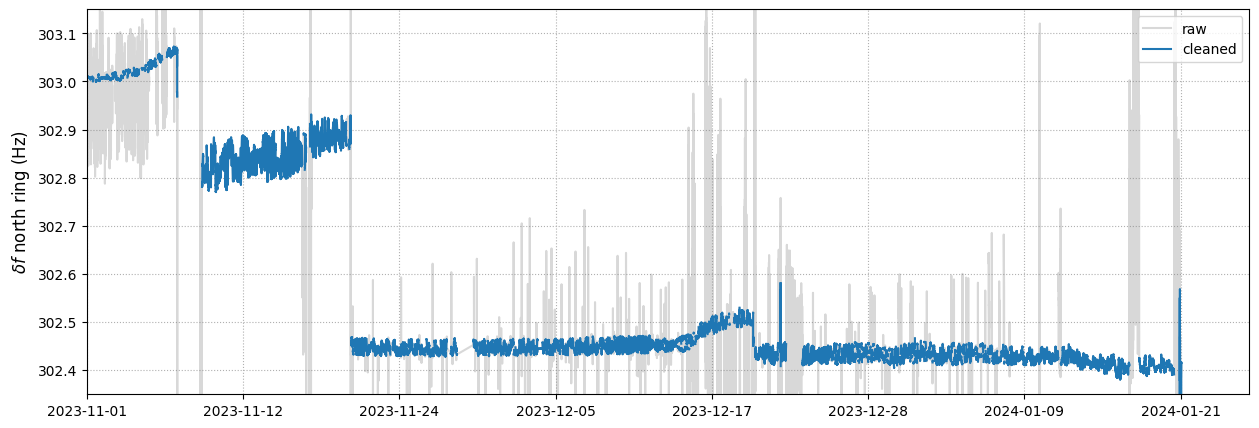

In [18]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(302.35, 303.15)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)


    ## add dates to x-axis
    ref_date = str(bs.time1.iloc[0])[:10]
    tcks = ax.get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax.set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_RU_longterm_cleaned.png", format="png", dpi=150, bbox_inches='tight')


## Load WROMY Data

In [19]:
from andbro__read_sds import __read_sds

In [20]:
ws1 = __read_sds(archive_path+"temp_archive/", "BW.WROMY.01.LKI", config['tbeg'], config['tend'])
ws5 = __read_sds(archive_path+"temp_archive/", "BW.WROMY.05.LKI", config['tbeg'], config['tend'])
ws9 = __read_sds(archive_path+"temp_archive/", "BW.WROMY.09.LKI", config['tbeg'], config['tend'])

In [21]:
ps3 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.03.LKI", config['tbeg'], config['tend'])

In [22]:
# from andbro__load_WROMY_stream import __load_wromy_stream

# ws1 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS1", config['tbeg'], config['tend'])
# ws5 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS5", config['tbeg'], config['tend'])
# ws9 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS9", config['tbeg'], config['tend'])

In [23]:
# plt.plot(bs[bs.time1 < "2023-11-20 14:00"].fj_fs)
# plt.ylim(302, 303)

/tmp/ipykernel_57218/1739043266.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[Nrow-1].set_xticklabels(tcklbls)


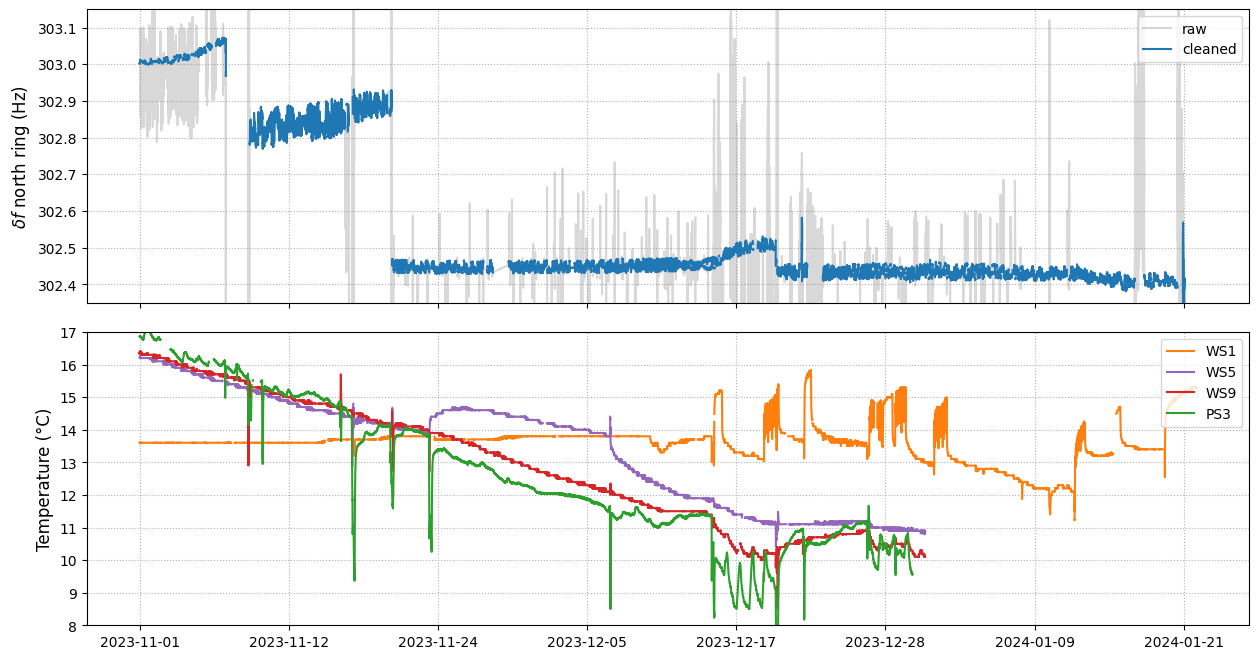

In [24]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    ref_date = str(bs.time1.iloc[0])[:10]

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[0].set_ylim(302.35, 303.15)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax[1].plot(ws1.select(channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(ws1.select(channel="*KI")[0].data, 600), color="tab:orange", label="WS1")
    ax[1].plot(ws5.select(channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(ws5.select(channel="*KI")[0].data, 600), color="tab:purple", label="WS5")
    ax[1].plot(ws9.select(channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(ws9.select(channel="*KI")[0].data, 600), color="tab:red", label="WS9")

    ax[1].plot(ps3.select(channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(ps3.select(channel="*KI")[0].data, 600), color="tab:green", label="PS3")

    ax[1].set_ylim(8, 17)
    ax[1].set_ylabel("Temperature (°C)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)
        # ax[_n].set_xlim(left=0)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_RU_longterm_temperature.png", format="png", dpi=150, bbox_inches='tight')


### Load Water Level Data

### Load Rain Data

In [25]:
from andbro__load_FURT_stream import __load_furt_stream

In [26]:
def __cumsum_rain(arr, n_samples):

    from numpy import cumsum, zeros, nansum, nanmean

    arr_out = zeros(len(arr))
    for i, dat in enumerate(arr):
        arr_out[i] = nansum(arr[i:i+n_samples])
        # arr_out[i] = nanmean(arr[i:i+n_samples])

    return arr_out

In [27]:
furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')

/home/brotzer/andbro_python/andbro__load_FURT_stream.py:105: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = read_csv(path_to_archive+filename, header=0, usecols=[0,1,5,8,10,12,13,14], names=['date', 'time', 'Dm', 'Sm', 'T', 'H', 'P','Rc'])


 -> NaN values found and removed from column date


/home/brotzer/andbro_python/andbro__load_FURT_stream.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = df["date"].astype(int)
/home/brotzer/andbro_python/andbro__load_FURT_stream.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = df['date'].astype(str).str.rjust(6,"0")+" "+df['time'].astype(str).str.rjust(6,"0")


In [28]:
rain = furt.select(channel="LAR")

In [29]:
## smoothed precipitation
rain_smooth = __smooth(__interpolate_nan(rain[0].data), 3600)

## cumulative rain
rain_cumsum = np.nancumsum(rain[0].data)

/tmp/ipykernel_57218/1704807410.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[Nrow-1].set_xticklabels(tcklbls)


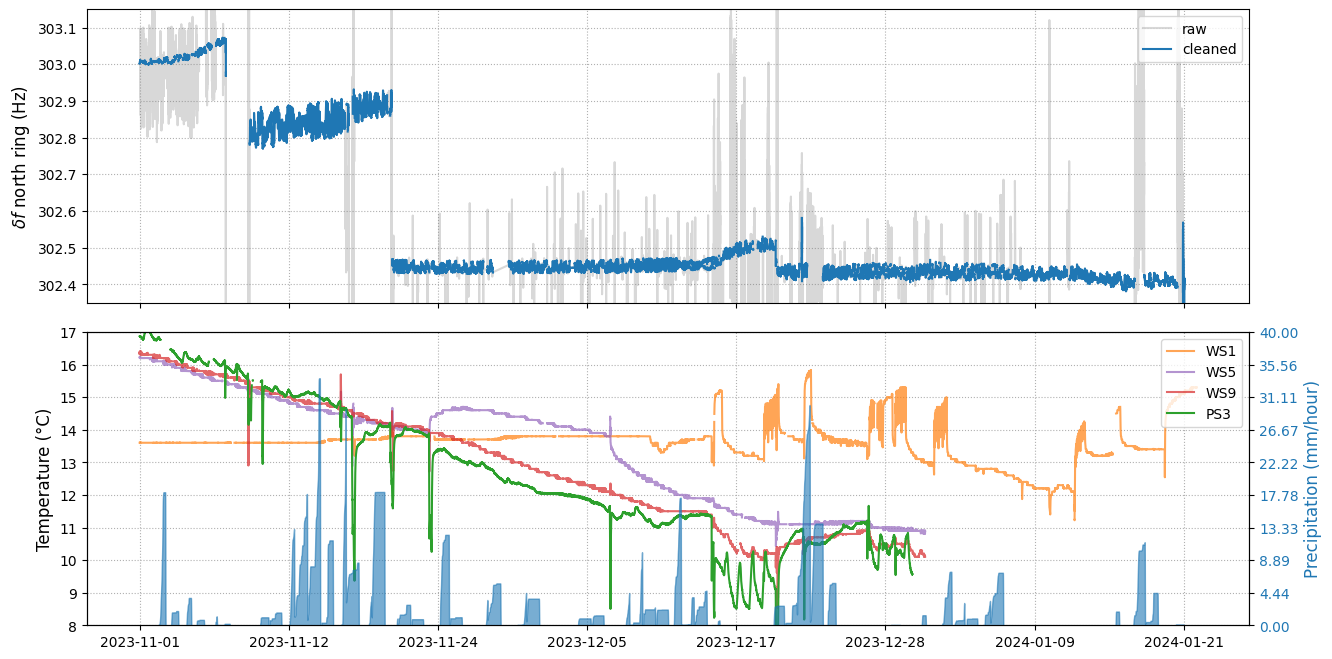

In [30]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    ref_date = str(bs.time1.iloc[0])[:10]

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[0].set_ylim(302.35, 303.15)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax[1].plot(ws1.select(channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(ws1.select(channel="*KI")[0].data, 600), color="tab:orange", label="WS1", alpha=0.7)
    ax[1].plot(ws5.select(channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(ws5.select(channel="*KI")[0].data, 600), color="tab:purple", label="WS5", alpha=0.7)
    ax[1].plot(ws9.select(channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(ws9.select(channel="*KI")[0].data, 600), color="tab:red", label="WS9", alpha=0.7)

    ax[1].plot(ps3.select(channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(ps3.select(channel="*KI")[0].data, 600), color="tab:green", label="PS3")

    ax[1].set_ylim(8, 17)
    ax[1].set_ylabel("Temperature (°C)", fontsize=font)

    ax11 = ax[1].twinx()
    ax11.fill_between(rain[0].times(reftime=UTCDateTime(ref_date)),
                      rain_smooth, color="tab:blue", alpha=0.6, label=f"rain", zorder=0)
    ax11.set_ylim(bottom=0)
    ax11.set_ylabel(f"Precipitation (mm/hour)", fontsize=font, color="tab:blue")
    [t.set_color('tab:blue') for t in ax11.yaxis.get_ticklabels()]

    ax[1].set_yticks(np.linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
    ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)
        # ax[_n].set_xlim(left=0)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_RU_longterm_temperature_rain.png", format="png", dpi=150, bbox_inches='tight')


### Load Tilt Data

In [31]:
from functions.conversion_to_tilt import __conversion_to_tilt

In [32]:
path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"

tromy0 =  __read_sds(path_to_tilt, "BW.TROMY..MAN", config['tbeg']+17*86400-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.TROMY..MAE", config['tbeg']+17*86400-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.TROMY..MAT", config['tbeg']+17*86400-600, config['tend']+600)

  -> converted data of TROMY


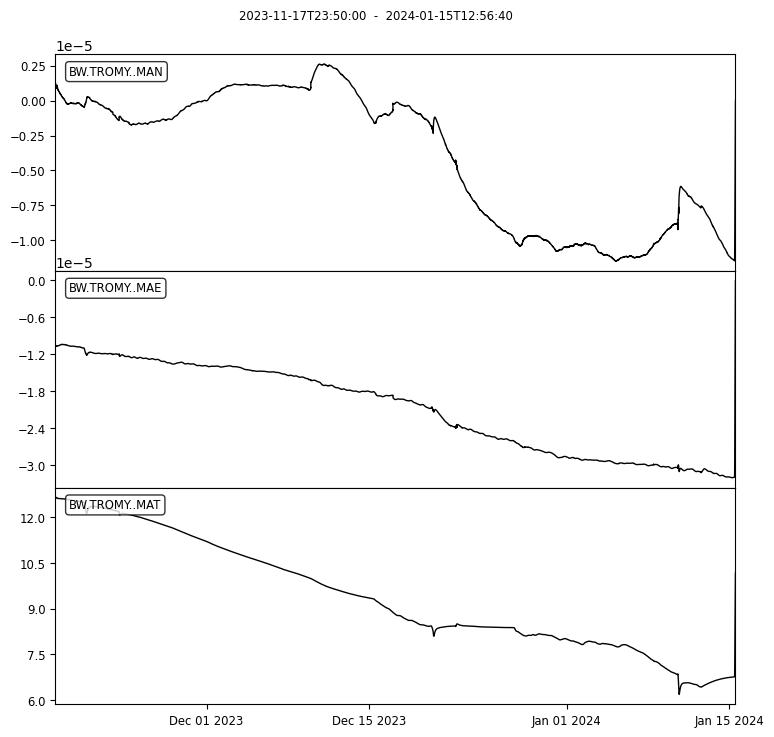

In [33]:
## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tromy0 = __conversion_to_tilt(tromy0, confTilt['TROMY'])

tromy0 = tromy0.trim(bs.time1[0], bs.time1[bs.time1.size-1]);

tromy = tromy0.copy();

tromy = tromy.merge();

tromy.plot(equal_scale=False);

In [36]:
# tromy.trim(tromy[0].stats.starttime+3600, tromy[0].stats.endtime-3600)

# ## correction for temperature trends based on MAT
# temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter_temperature_correction.yml")

# tromy_mod = __correct_temperature_trend(tromy, temperature_correction['TROMY'], n_shift=0, intercept=False)

# tromy_mod.plot(equal_scale=False);

### Load Water Level Data

In [96]:
def __load_water_level(tbeg, tend):

    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range
    from obspy import UTCDateTime

    path_to_data = "/lamont/Pegel/"

    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    if tbeg < UTCDateTime("2023-11-26"):
        print(f" -> no good data before 2023-11-26!")
        tbeg = UTCDateTime("2023-11-27")

    dd1 = date.fromisoformat(str(tbeg.date))
    dd2 = date.fromisoformat(str(tend.date))

    df = DataFrame()
    for dat in date_range(dd1, dd2):
        file = f"{str(dat)[:4]}/PG"+str(dat)[:10].replace("-", "")+".dat"
        try:
            df0 = read_csv(path_to_data+file, delimiter=" ")
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    ## correct seconds
    df['times_utc'] = [UTCDateTime(f"{_d[-4:]+_d[3:5]+_d[:2]} {_t}")  for _d, _t in zip(df['day'], df['hour'])]
    df['times_utc_sec'] = [abs(tbeg - UTCDateTime(_t))  for _t in df['times_utc']]

    ## remove columns hour and day
    df.drop(columns=["hour", "day"], inplace=True)

    ## reset index to make it continous
    df.reset_index(inplace=True)

    if df.empty:
        print(" -> empty dataframe!")
        return df

    # trim to defined times
    df = df[(df.times_utc >= tbeg) & (df.times_utc < tend)]
    return df

pegel =  __load_water_level(config['tbeg'], config['tend'])

## remove error measurements with nan
pegel['pegel'] = np.where(pegel.pegel <= 0, np.nan, pegel.pegel)


 -> no good data before 2023-11-26!


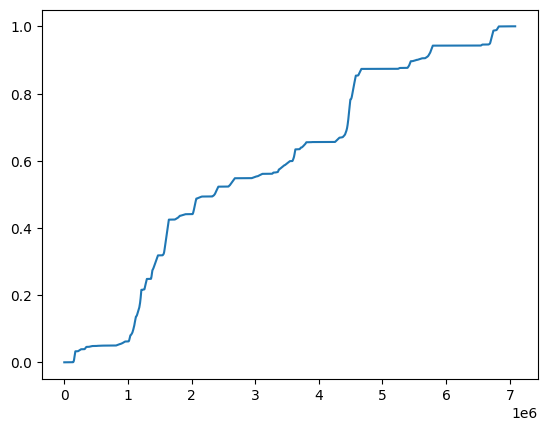

/tmp/ipykernel_57218/2998068630.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[Nrow-1].set_xticklabels(tcklbls)


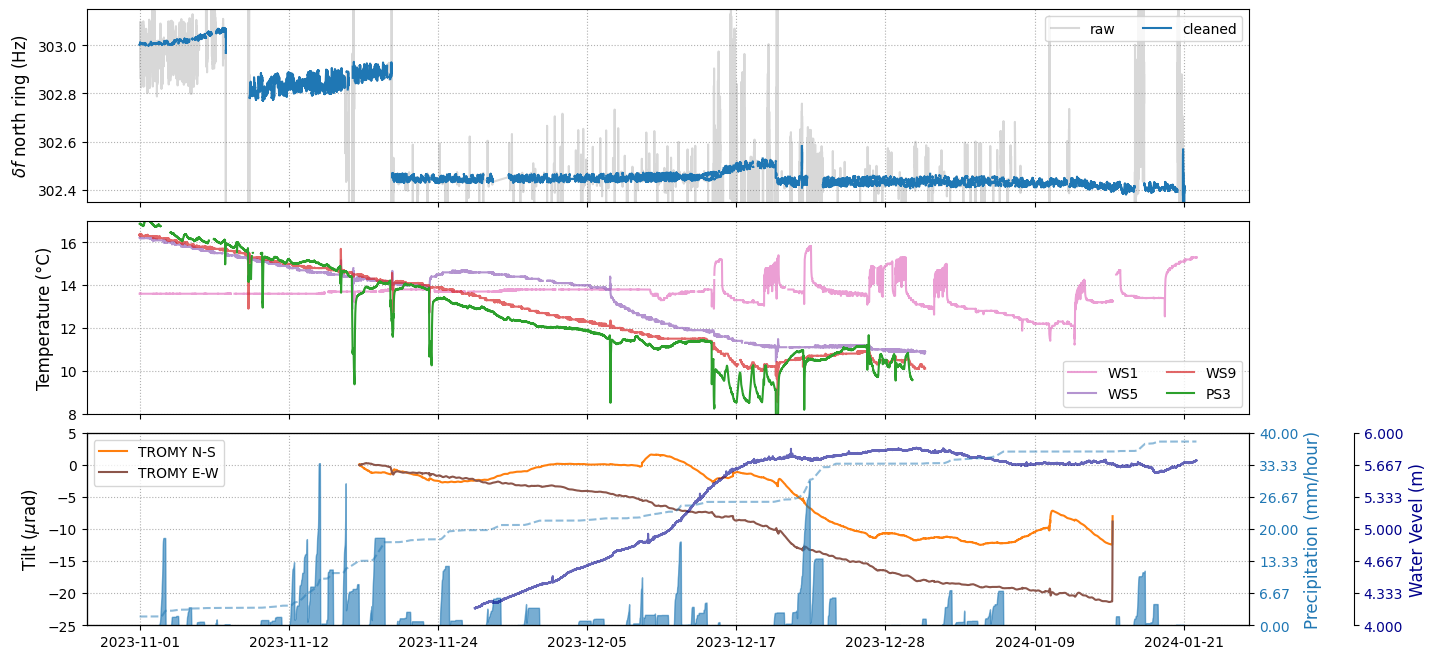

In [126]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    ref_date = str(bs.time1.iloc[0])[:10]

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[0].set_ylim(302.35, 303.15)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax[1].plot(ws1.select(channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(ws1.select(channel="*KI")[0].data, 600), color="tab:pink", label="WS1", alpha=0.7)
    ax[1].plot(ws5.select(channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(ws5.select(channel="*KI")[0].data, 600), color="tab:purple", label="WS5", alpha=0.7)
    ax[1].plot(ws9.select(channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(ws9.select(channel="*KI")[0].data, 600), color="tab:red", label="WS9", alpha=0.7)

    ax[1].plot(ps3.select(channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
               __smooth(ps3.select(channel="*KI")[0].data, 600), color="tab:green", label="PS3")

    ax[1].set_ylim(8, 17)
    ax[1].set_ylabel("Temperature (°C)", fontsize=font)



    ax[2].plot(tromy.select(channel="*N")[0].times(reftime=UTCDateTime(ref_date)),
               __reduce(tromy.select(channel="*N")[0].data, 100)*1e6, label="TROMY N-S", color="tab:orange")
    ax[2].plot(tromy.select(channel="*E")[0].times(reftime=UTCDateTime(ref_date)),
               __reduce(tromy.select(channel="*E")[0].data, 100)*1e6, label="TROMY E-W", color="tab:brown")
    ax[2].set_ylabel("Tilt ($\mu$rad)", fontsize=font)


    ax22 = ax[2].twinx()
    ax22.fill_between(rain[0].times(reftime=UTCDateTime(ref_date)),
                      rain_smooth, color="tab:blue", alpha=0.6, label=f"rain", zorder=0)
    ax22.set_ylim(bottom=0)
    ax22.set_ylabel(f"Precipitation (mm/hour)", fontsize=font, color="tab:blue")
    [t.set_color('tab:blue') for t in ax22.yaxis.get_ticklabels()]

    ax[2].set_yticks(np.linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
    ax22.set_yticks(np.linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))


    ax23 = ax[2].twinx()
    ax23.spines.right.set_position(("axes", 1.09))
    ax23.plot(pegel.times_utc - UTCDateTime(ref_date), pegel.pegel, color="darkblue", alpha=0.6)
    # ax23.set_ylim(bottom=0)
    ax23.set_ylabel(f"Water Vevel (m)", fontsize=font, color="darkblue")
    [t.set_color('darkblue') for t in ax23.yaxis.get_ticklabels()]

    ax[2].set_yticks(np.linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
    ax23.set_yticks(np.linspace(ax23.get_yticks()[0], ax23.get_yticks()[-1], len(ax[2].get_yticks())))

    ax24 = ax[2].twinx()
    ax24.plot(rain_cumsum/max(rain_cumsum), alpha=0.5, zorder=1, ls="--")
    ax24.axis('off')

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        # ax[_n].legend(loc=1, ncol=2)
        # ax[_n].set_xlim(left=0)

    ax[0].legend(loc=1, ncol=2)
    ax[1].legend(loc=4, ncol=2)
    ax[2].legend(loc=2, ncol=1)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig


fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_RU_longterm_temperature_rain_tilt.png", format="png", dpi=150, bbox_inches='tight')


### Convert beat to tilt

$\delta$ f = S * $\Omega_E$ * sin($\phi_{lat}$ + $\theta_{dip}$ + $\epsilon_{tilt}$)

$\epsilon_{tilt}$ = arcsin( $\delta$ f / S / $\Omega_E$ ) - $\phi_{lat}$ - $\theta_{dip}$

In [ ]:
from functions.sagnac_to_tilt import __sagnac_to_tilt
from functions.conversion_to_tilt import __conversion_to_tilt

In [ ]:
# fs_tilt = __sagnac_to_tilt(bs.w_s_inter, "U")

# plt.plot(fs_tilt)

### LowPass Version

In [ ]:
tromy_lp = tromy0.copy()
tromy_lp = tromy_lp.detrend("simple")
tromy_lp = tromy_lp.taper(0.1)
# tromy_lp = tromy_lp.filter("lowpass", freq=0.01, corners=4, zerophase=True)
tromy_lp = tromy_lp.filter("bandpass", freqmin=1/(10*86400), freqmax=1/(1*3600), corners=4, zerophase=True)
tromy_lp = tromy_lp.resample(1/(1*3600), no_filter=True)

tromy_lp.merge()
tromy_lp.plot(equal_scale=False);

In [ ]:
gc.collect()

In [ ]:
from obspy.signal.cross_correlation import correlate, xcorr_max

arr1 = np.nan_to_num(tromy_lp.select(channel="*T")[0].data, 0)
arr2 = np.nan_to_num(tromy_lp.select(channel="*N")[0].data, 0)

# arr1 = __interpolate_nan(tromy_lp.select(channel="*T")[0].data)
# arr2 = __interpolate_nan(tromy_lp.select(channel="*N")[0].data)

Nshift = len(arr1)
ccf = correlate(arr1, arr2, shift=Nshift, demean=True, normalize='naive', method='fft')
cclags = np.arange(-Nshift, Nshift+1)

shift, value = xcorr_max(ccf)
print("Nshift: ", shift, "Tshift: ", shift*tromy_lp[0].stats.delta, "CC: ", value)

cclag = shift

plt.plot(cclags, ccf)

In [ ]:
arr1 = np.nan_to_num(tromy_lp.select(channel="*N")[0].data, 0)
arr2 = np.nan_to_num(tromy_lp.select(channel="*T")[0].data, 0)


fig, ax = plt.subplots(4, 1, figsize=(15, 8))

ax[0].plot(arr1, label="tilt")
ax[0].plot(-arr2*1e-5, label="-1 temperature")
correct = np.roll(arr2, -cclag)
ax[0].plot(-correct*1e-5, label="shifted -1 temperature")

ax[0].legend()

ax[1].plot(arr1, label="tilt")
ax[1].plot(arr1 + arr2*1e-5, label="tilt corrected")
ax[1].plot(arr1 + correct*1.2e-5, label="tilt corrected")

ax[1].legend()

ax[2].scatter(arr2, arr1, s=1)
ax[2].scatter(correct, arr1, s=1)

plt.show();

In [ ]:
from functions.multitaper_coherence import __multitaper_coherence

dat1 = tromy.select(channel="*T")[0].data
dat2 = tromy.select(channel="*N")[0].data
dt = tromy[0].stats.delta


out = __multitaper_coherence(dat1, dat2, dt, n_taper=10, time_bandwidth=3.5, method=2)


f1, psd1, pha1 = __get_fft(dat1, dt)
f2, psd2, pha2 = __get_fft(dat2, dt)



fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

ax[0].semilogx(1/out['fcoh'], out['coh'])
ax[0].set_ylim(0, 1)

ax[1].semilogx(1/out['ff1'], out['psd1'])
ax[2].semilogx(1/out['ff2'], out['psd2'])

ax11 = ax[1].twinx()
ax11.semilogx(1/f1, psd1, color="tab:orange")

ax22 = ax[2].twinx()
ax22.semilogx(1/f2, psd2, color="tab:orange")

plt.show();